In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
        

In [0]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [3]:
data_dir = './inception_model'
path_pb = 'classify_image_graph_def.pb'
path = os.path.join(data_dir, path_pb)
graph = tf.Graph()

with graph.as_default() :
    #file 주소값
    with tf.gfile.FastGFile(path, 'rb') as file:
        graph_def  = tf.GraphDef()

        #string으로 read함
        graph_def.ParseFromString(file.read())
        tf.import_graph_def(graph_def, name = '')
        g = tf.get_default_graph()
        print(g)

W0711 09:46:04.840469 140317639923584 deprecation.py:323] From <ipython-input-3-1703d22eb271>:8: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.


In [4]:
with graph.as_default() :
    resized_image = graph.get_tensor_by_name("ResizeBilinear:0")
    print(resized_image)
    
    weights = graph.get_tensor_by_name("mixed_6/join:0")
    print(weights)


Tensor("ResizeBilinear:0", shape=(1, 299, 299, 3), dtype=float32)
Tensor("mixed_6/join:0", shape=(1, 17, 17, 768), dtype=float32)


Tensor("Mean:0", shape=(), dtype=float32)
Tensor("gradients/Sub_grad/Reshape:0", shape=(1, 299, 299, 3), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32)
Tensor("gradients_1/Sub_grad/Reshape:0", shape=(1, 299, 299, 3), dtype=float32)
Tensor("Mean_2:0", shape=(), dtype=float32)
Tensor("gradients_2/Sub_grad/Reshape:0", shape=(1, 299, 299, 3), dtype=float32)
Tensor("Mean_3:0", shape=(), dtype=float32)
Tensor("gradients_3/Sub_grad/Reshape:0", shape=(1, 299, 299, 3), dtype=float32)
Tensor("Mean_4:0", shape=(), dtype=float32)
Tensor("gradients_4/Sub_grad/Reshape:0", shape=(1, 299, 299, 3), dtype=float32)
Tensor("Mean_5:0", shape=(), dtype=float32)
Tensor("gradients_5/Sub_grad/Reshape:0", shape=(1, 299, 299, 3), dtype=float32)
Tensor("Mean_6:0", shape=(), dtype=float32)
Tensor("gradients_6/Sub_grad/Reshape:0", shape=(1, 299, 299, 3), dtype=float32)
Tensor("Mean_7:0", shape=(), dtype=float32)
Tensor("gradients_7/Sub_grad/Reshape:0", shape=(1, 299, 299, 3), dtype=float32)
Tensor("Mean

<function matplotlib.pyplot.show>

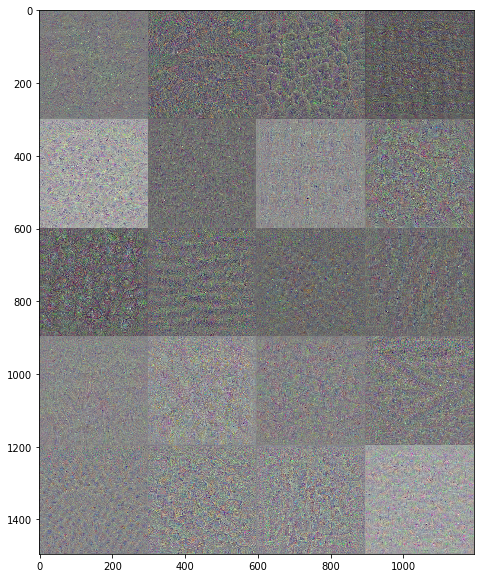

In [5]:
# exit() <- 디버그할때 꺼지는지 안꺼지는지 확인할 수 있음
# Kernel visualization and training
with graph.as_default() :
    
    list_filter = []
    sess = tf.Session(graph = graph)
    
    for im in range(20) :
        
        #filter 하나 뽑은 후 하나의 점으로 만듬=> vis_loss, 미분하기 위함
        pattern_loss = tf.reduce_mean(weights[:,:,:,im])
        print(pattern_loss)

        #resize_image가 loss에 대해 어떻게 변하는가  : del loss / del resized_image
        #!!!grad는 pattern값을 list 반환하기에 [0]으로 꺼내야함
        pattern_grad = tf.gradients(pattern_loss, resized_image)[0]
        print(pattern_grad)
        
        #norm되지 않은상태라 128더함        
        image = np.random.uniform(size = resized_image.get_shape()) + 128.0
        
        for i in range(100) :
            feed_dict = {resized_image: image}
            grad, loss_value = sess.run([pattern_grad, pattern_loss],
                                             feed_dict = feed_dict)
            #(299,299,3)으로 squeeze
            grad = np.array(grad).squeeze()

            step_size = 1.0 / (grad.std() + 1e-8)

            #Gradient ascent부분
            image += step_size * grad

            #값을 0-255 사이로 줄임
            image = np.clip(image, 0.0, 255.0)

        image = (image[0] - image[0].min()) / (image[0].max() - image[0].min())
        list_filter.append(image)
            
merged_image = np.stack(list_filter)
print(merged_image.shape)
merged_image = merged_image.reshape(5,4,299,299,3).\
                            transpose([0,2,1,3,4]).reshape([5*299, 4*299, 3])


<function matplotlib.pyplot.show>

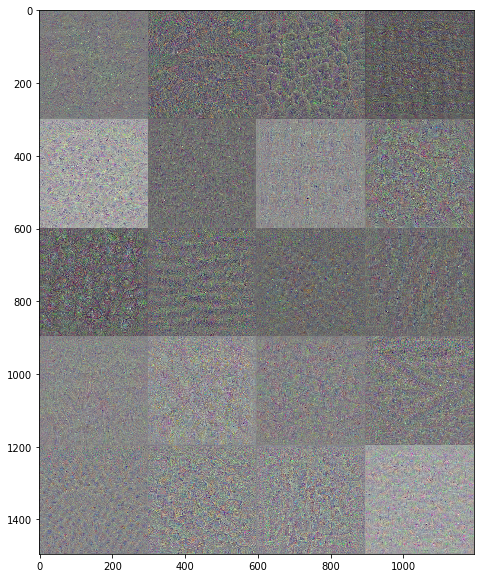

In [6]:
plt.figure(figsize = (10,10))
plt.imshow(merged_image)
plt.show